In [1]:
include("graph_ops.jl")
import Base: show, summary
show(io::IO, x::OperationNode{F}) where {F} = print(io, "op ", "?", "(", F, ")");
show(io::IO, x::ConstantNode) = print(io, "const ", x.output)
show(io::IO, x::VariableNode) = begin
    print(io, "var ", "?");
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

pprint(nodes::Vector{<:Node}) = for node in nodes; println(node); end


pprint (generic function with 1 method)

In [8]:
include("graph_ops.jl")

net = build_net(mean_squared_loss,
Dense( 1 => 64, tanh),
Dense( 64 => 64, tanh),
Dense( 64 => 64, tanh),
Dense( 64 => 1, nothing)
)

graph = net.graph
# pprint(graph)

new Dense: dims(Wx): (64, 1, " b: ", 64)
new Dense: dims(Wx): (64, 64, " b: ", 64)
new Dense: dims(Wx): (64, 64, " b: ", 64)
new Dense: dims(Wx): (1, 64, " b: ", 1)


26-element Vector{Node}:
 const [0.5]
 var ?
 ┣━ ^ 1×64 Matrix{Float64}
 ┗━ ∇ 1×64 Matrix{Float64}
 var ?
 ┣━ ^ 64×64 Matrix{Float64}
 ┗━ ∇ 64×64 Matrix{Float64}
 var ?
 ┣━ ^ 64×64 Matrix{Float64}
 ┗━ ∇ 64×64 Matrix{Float64}
 var ?
 ┣━ ^ 64×1 Matrix{Float64}
 ┗━ ∇ 64×1 Matrix{Float64}
 InputNode([0.0], "?")
 op ?(typeof(mul!))
 var ?
 ┣━ ^ 64-element Vector{Float64}
 ┗━ ∇ 64-element Vector{Float64}
 op ?(typeof(+))
 op ?(typeof(tanh))
 ⋮
 op ?(typeof(tanh))
 op ?(typeof(mul!))
 var ?
 ┣━ ^ 1-element Vector{Float64}
 ┗━ ∇ 1-element Vector{Float64}
 op ?(typeof(+))
 InputNode([0.0], "?")
 op ?(typeof(-))
 const [2]
 op ?(typeof(^))
 op ?(typeof(*))

In [3]:
import Base: sin
data = [([i], [sin(i)]) for i in 0:0.1:7]

71-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.0], [0.0])
 ([0.1], [0.09983341664682815])
 ([0.2], [0.19866933079506122])
 ([0.3], [0.29552020666133955])
 ([0.4], [0.3894183423086505])
 ([0.5], [0.479425538604203])
 ([0.6], [0.5646424733950354])
 ([0.7], [0.644217687237691])
 ([0.8], [0.7173560908995228])
 ([0.9], [0.7833269096274834])
 ⋮
 ([6.2], [-0.0830894028174964])
 ([6.3], [0.016813900484349713])
 ([6.4], [0.11654920485049364])
 ([6.5], [0.21511998808781552])
 ([6.6], [0.31154136351337786])
 ([6.7], [0.4048499206165983])
 ([6.8], [0.49411335113860816])
 ([6.9], [0.5784397643882002])
 ([7.0], [0.6569865987187891])

In [12]:
n_epochs = 1000
lr = 0.01
data_size = length(data)
losses = Float64[]
x = net.input
y = net.desired_output

@time for epoch in 1:n_epochs
    reset!(graph)
    loss_in_epoch = 0
    for (x_, y_) in data
        x.output = x_
        y.output = y_
        currentloss = forward!(graph)
        backward!(graph)
        loss_in_epoch += first(currentloss)
        # println("Current loss: ", currentloss)
    end
    # println(graph[2].gradient)
    adjust!(net.variables, lr/data_size)
    println("Current loss: ", loss_in_epoch/data_size)
    push!(losses, first(loss_in_epoch/data_size))
end


Current loss: 0.00226502129567587
Current loss: 0.0022560125229875868
Current loss: 0.0022470540615104084
Current loss: 0.002238145514274807
Current loss: 0.0022292864881659756
Current loss: 0.0022204765938903795
Current loss: 0.0022117154459427744
Current loss: 0.0022030026625731274
Current loss: 0.002194337865753665
Current loss: 0.0021857206811460323
Current loss: 0.0021771507380686905
Current loss: 0.002168627669464237
Current loss: 0.002160151111867132
Current loss: 0.002151720705371204
Current loss: 0.002143336093597549
Current loss: 0.0021349969236624518
Current loss: 0.0021267028461455094
Current loss: 0.002118453515057655
Current loss: 0.002110248587809789
Current loss: 0.002102087725180969
Current loss: 0.002093970591287236
Current loss: 0.002085896853550179
Current loss: 0.002077866182666041
Current loss: 0.00206987825257469
Current loss: 0.002061932740428744
Current loss: 0.00205402932656303
Current loss: 0.0020461676944639354
Current loss: 0.0020383475307395142
Current los

In [5]:
import Base: sin
data_dense_x = 0:0.1:7
data_dense_y = sin.(data_dense_x)

using Plots
xx = 0:0.01:7
yy = Vector{Float64}(undef, length(xx))

701-element Vector{Float64}:
 3.5e-323
 3.5e-323
 1.2640829503826e-311
 1.2640829504143e-311
 4.0e-323
 4.0e-323
 1.264082950446e-311
 1.2640829504775e-311
 4.4e-323
 8.4e-323
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

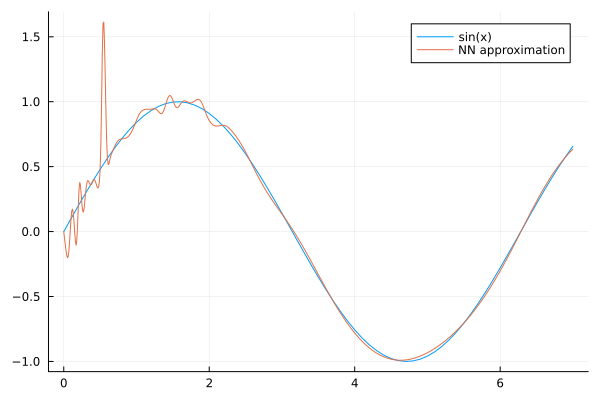

In [13]:


for i in 1:length(xx)
    yy[i] = predict!([xx[i]], x,net.output, graph)[1]
end

plot(data_dense_x, data_dense_y, label="sin(x)")
plot!(xx, yy, label="NN approximation")
